In [1]:
import os
import numpy as np
import importlib
import time
import logging
from contextlib import contextmanager

In [2]:
from constants import ENVIRONMENT_PATH
import calculations as calculations
import plotter as plotter

In [3]:
do_preliminary_analysis_1 = False
do_preliminary_analysis_2 = True

In [4]:
logging.basicConfig(level=logging.INFO, format="%(message)s")


@contextmanager
def time_block(label: str):
    """
    Context manager for timing a block of code and logging the elapsed time.

    Parameters:
    ----------
    label : str
        A label for the block of code being timed.
    """
    start_time = time.time()
    yield  # This runs the block of code
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info(f"took {elapsed_time:.2f} seconds, {label}")

## Preliminary Analysis #1

- Display y-z plane evolution of large-scale circulation
- Seasonal transition of large-scale circulation
- Shallow circulation and vertical MSE flux convergence
- Onset correlates with shallow convection and boundary flux

In [5]:
if do_preliminary_analysis_1:
    with time_block("Preliminary Analysis #1, Calculation"):
        with time_block("Zonal Wind Shear Calculation"):
            zws_raw, zws_smooth, zws_smooth_grad = (
                calculations.calculate_zonal_wind_shear(
                    os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "u.nc")
                )
            )
            years = np.arange(1979, 2022)
            onset_days = np.argmax(zws_smooth > 0, axis=1)
            monsoon_onset = dict(zip(years.tolist(), onset_days.tolist()))

            monsoon_onset_sorted = dict(
                sorted(monsoon_onset.items(), key=lambda item: item[1])
            )
        with time_block("Tropical Cyclone Occurrence Calculation"):
            occurrence_raw, occurrence_smooth = calculations.calculate_occurrence(
                os.path.join(
                    ENVIRONMENT_PATH.ABSOLUTE_PATH_TEMPEST,
                    "TropicalCycloneCount_925.csv",
                )
            )
        with time_block("Meridional Mean Zonal Mass Stream Function"):
            streamfunction_raw, streamfunction_smooth, streamfunction_grids = (
                calculations.calculate_streamfunction(
                    os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "divergent_uv.nc")
                )
            )
        with time_block("Meridional Mean Potential Temperature"):
            (
                potential_temperature_raw,
                potential_temperature_smooth,
                potential_temperature_grids,
            ) = calculations.calculate_potential_temperature(
                os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "theta.nc")
            )
        with time_block("Meridional Mean Equivalent Potential Temperature"):
            (
                equivalent_potential_temperature_raw,
                equivalent_potential_temperature_smooth,
                equivalent_potential_temperature_grids,
            ) = calculations.calculate_equivalent_potential_temperature(
                os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "equiv_theta.nc")
            )
        with time_block("Meridional Mean Moist Static Energy Vertical Flux"):
            mse_flux_raw, mse_flux_smooth, mse_flux_grids = (
                calculations.calculate_MSE_vertical_flux(
                    os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "MSE.nc"),
                    os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "w.nc"),
                )
            )
    with time_block("Preliminary Analysis #2, Plot"):
        with time_block("Pre Plot Calculation"):
            # Parameters
            start = 90  # Calendar day
            step = 90  # Days

            sorted_indices = np.argsort(list(monsoon_onset.values()))
            early_onset_indices = sorted_indices[:10]
            late_onset_indices = sorted_indices[-10:]

            streamfunction_early_composite = np.mean(
                streamfunction_smooth[early_onset_indices], axis=0
            )
            streamfunction_late_composite = np.mean(
                streamfunction_smooth[late_onset_indices], axis=0
            )
            potential_temperature_early_composite = np.mean(
                potential_temperature_smooth[early_onset_indices], axis=0
            )
            potential_temperature_late_composite = np.mean(
                potential_temperature_smooth[late_onset_indices], axis=0
            )
            equivalent_potential_temperature_early_composite = np.mean(
                equivalent_potential_temperature_smooth[early_onset_indices], axis=0
            )
            equivalent_potential_temperature_late_composite = np.mean(
                equivalent_potential_temperature_smooth[late_onset_indices], axis=0
            )
            mse_flux_early_composite = np.mean(
                mse_flux_smooth[early_onset_indices], axis=0
            )
            mse_flux_late_composite = np.mean(
                mse_flux_smooth[late_onset_indices], axis=0
            )

            mse_flux_early_divergence = np.gradient(
                mse_flux_early_composite, mse_flux_grids["plev"] * 100, axis=1
            )
            mse_flux_late_divergence = np.gradient(
                mse_flux_late_composite, mse_flux_grids["plev"] * 100, axis=1
            )
        with time_block("Zonal Wind Shear Difference Chart"):
            figure_object = plotter.display_ZWS_evolution(
                (zws_raw, zws_smooth, zws_smooth_grad, occurrence_smooth)
            )
            _ = figure_object.savefig(
                os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES, "ZWS_chart.png")
            )
        with time_block("Meridional Mean Zonal Mass Stream Function"):
            animation_object = plotter.display_streamfunction_composites_evolution(
                streamfunction_composite=(
                    streamfunction_early_composite,
                    streamfunction_late_composite,
                ),
                grids=streamfunction_grids,
                start=start,
                step=step,
            )
            _ = animation_object.save(
                os.path.join(
                    ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
                    "streamfunction_composites.mp4",
                )
            )
        with time_block("Meridional Mean Potential temperature"):
            animation_object = (
                plotter.display_potential_temperature_composites_evolution(
                    potential_temperature_composite=(
                        potential_temperature_early_composite,
                        potential_temperature_late_composite,
                    ),
                    grids=potential_temperature_grids,
                    start=start,
                    step=step,
                )
            )
            _ = animation_object.save(
                os.path.join(
                    ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
                    "potential_temperature_composites.mp4",
                )
            )
        with time_block("Meridional Mean Equivalent Potential temperature"):
            animation_object = (
                plotter.display_equivalent_potential_temperature_composites_evolution(
                    equivalent_potential_temperature_composite=(
                        equivalent_potential_temperature_early_composite,
                        equivalent_potential_temperature_late_composite,
                    ),
                    grids=equivalent_potential_temperature_grids,
                    start=start,
                    step=step,
                )
            )
            _ = animation_object.save(
                os.path.join(
                    ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
                    "equivalent_potential_temperature_composites.mp4",
                )
            )
        with time_block(
            "Meridional Mean Potential temperature and Mass Stream Function"
        ):
            animation_object = plotter.display_streamfunction_and_potential_temperature_composite_evolution(
                streamfunction_early_composite=streamfunction_early_composite,
                streamfunction_grids=streamfunction_grids,
                potential_temperature_early_composite=potential_temperature_early_composite,
                potential_temperature_grids=potential_temperature_grids,
                start=start,
                step=step,
            )
            _ = animation_object.save(
                os.path.join(
                    ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
                    "streamfunction_and_theta_composites.mp4",
                )
            )
        with time_block(
            "Meridional Mean Equivalent Potential temperature and Mass Stream Function"
        ):
            animation_object = plotter.display_streamfunction_and_equivalent_potential_temperature_composite_evolution(
                streamfunction_early_composite=streamfunction_early_composite,
                streamfunction_grids=streamfunction_grids,
                equivalent_potential_temperature_early_composite=equivalent_potential_temperature_early_composite,
                equivalent_potential_temperature_grids=equivalent_potential_temperature_grids,
                start=start,
                step=step,
            )
            _ = animation_object.save(
                os.path.join(
                    ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
                    "streamfunction_and_equiv_theta_composites.mp4",
                )
            )
        with time_block("Meridional Mean Moist Static Energy Vertical Flux"):
            animation_object = plotter.display_mse_flux_composites_evolution(
                mse_flux_composite=(mse_flux_early_composite, mse_flux_late_composite),
                grids=mse_flux_grids,
                start=start,
                step=step,
            )
            _ = animation_object.save(
                os.path.join(
                    ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES, "MSE_composites.mp4"
                )
            )
        with time_block(
            "Meridional Mean Divergence of Moist Static Energy Vertical Flux"
        ):
            animation_object = plotter.display_mse_flux_divergence_composites_evolution(
                mse_flux_divergence_composite=(
                    mse_flux_early_divergence,
                    mse_flux_late_divergence,
                ),
                grids=mse_flux_grids,
                start=start,
                step=step,
            )
            _ = animation_object.save(
                os.path.join(
                    ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
                    "MSE_divergence_composites.mp4",
                )
            )
        with time_block(
            "Meridional Mean Moist Static Energy Vertical Flux and Mass Stream Function"
        ):
            animation_object = (
                plotter.display_streamfunction_and_mse_flux_composite_evolution(
                    streamfunction_early_composite=streamfunction_early_composite,
                    streamfunction_grids=streamfunction_grids,
                    mse_flux_early_composite=mse_flux_early_composite,
                    mse_flux_grids=mse_flux_grids,
                    start=start,
                    step=step,
                )
            )
            _ = animation_object.save(
                os.path.join(
                    ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
                    "streamfunction_and_MSE_composites.mp4",
                )
            )

## Preliminary Analysis #2

- Display wavenumber-frequency diagram
- Detect significant equatorial wave signals if possible

In [6]:
if do_preliminary_analysis_2:
    with time_block("Wavenumber-Frequency Diagram"):
        # filepath = os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "sparse_vor.nc")
        filepath = os.path.join(
            ENVIRONMENT_PATH.ABSOLUTE_PATH_SATELLITE_TEST, "OLR_sparse.nc"
        )
        varname = "olr"
        (symmetric_PSD, antisymmetric_PSD, background_PSD), grids = (
            calculations.calculate_SPSD(file_path=filepath, variable_name=varname)
        )

took 11.81 seconds, Wavenumber-Frequency Diagram


took 0.33 seconds, Plotting of Stochastic Power Spectra Density Ratio
Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2560x1440 -pix_fmt rgba -framerate 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/b08209033/IndianMonsoon/img/olr_wavenumber_frequency_diagram_evolution.mp4
took 4.46 seconds, Wavenumber-Frequency Diagram TEST


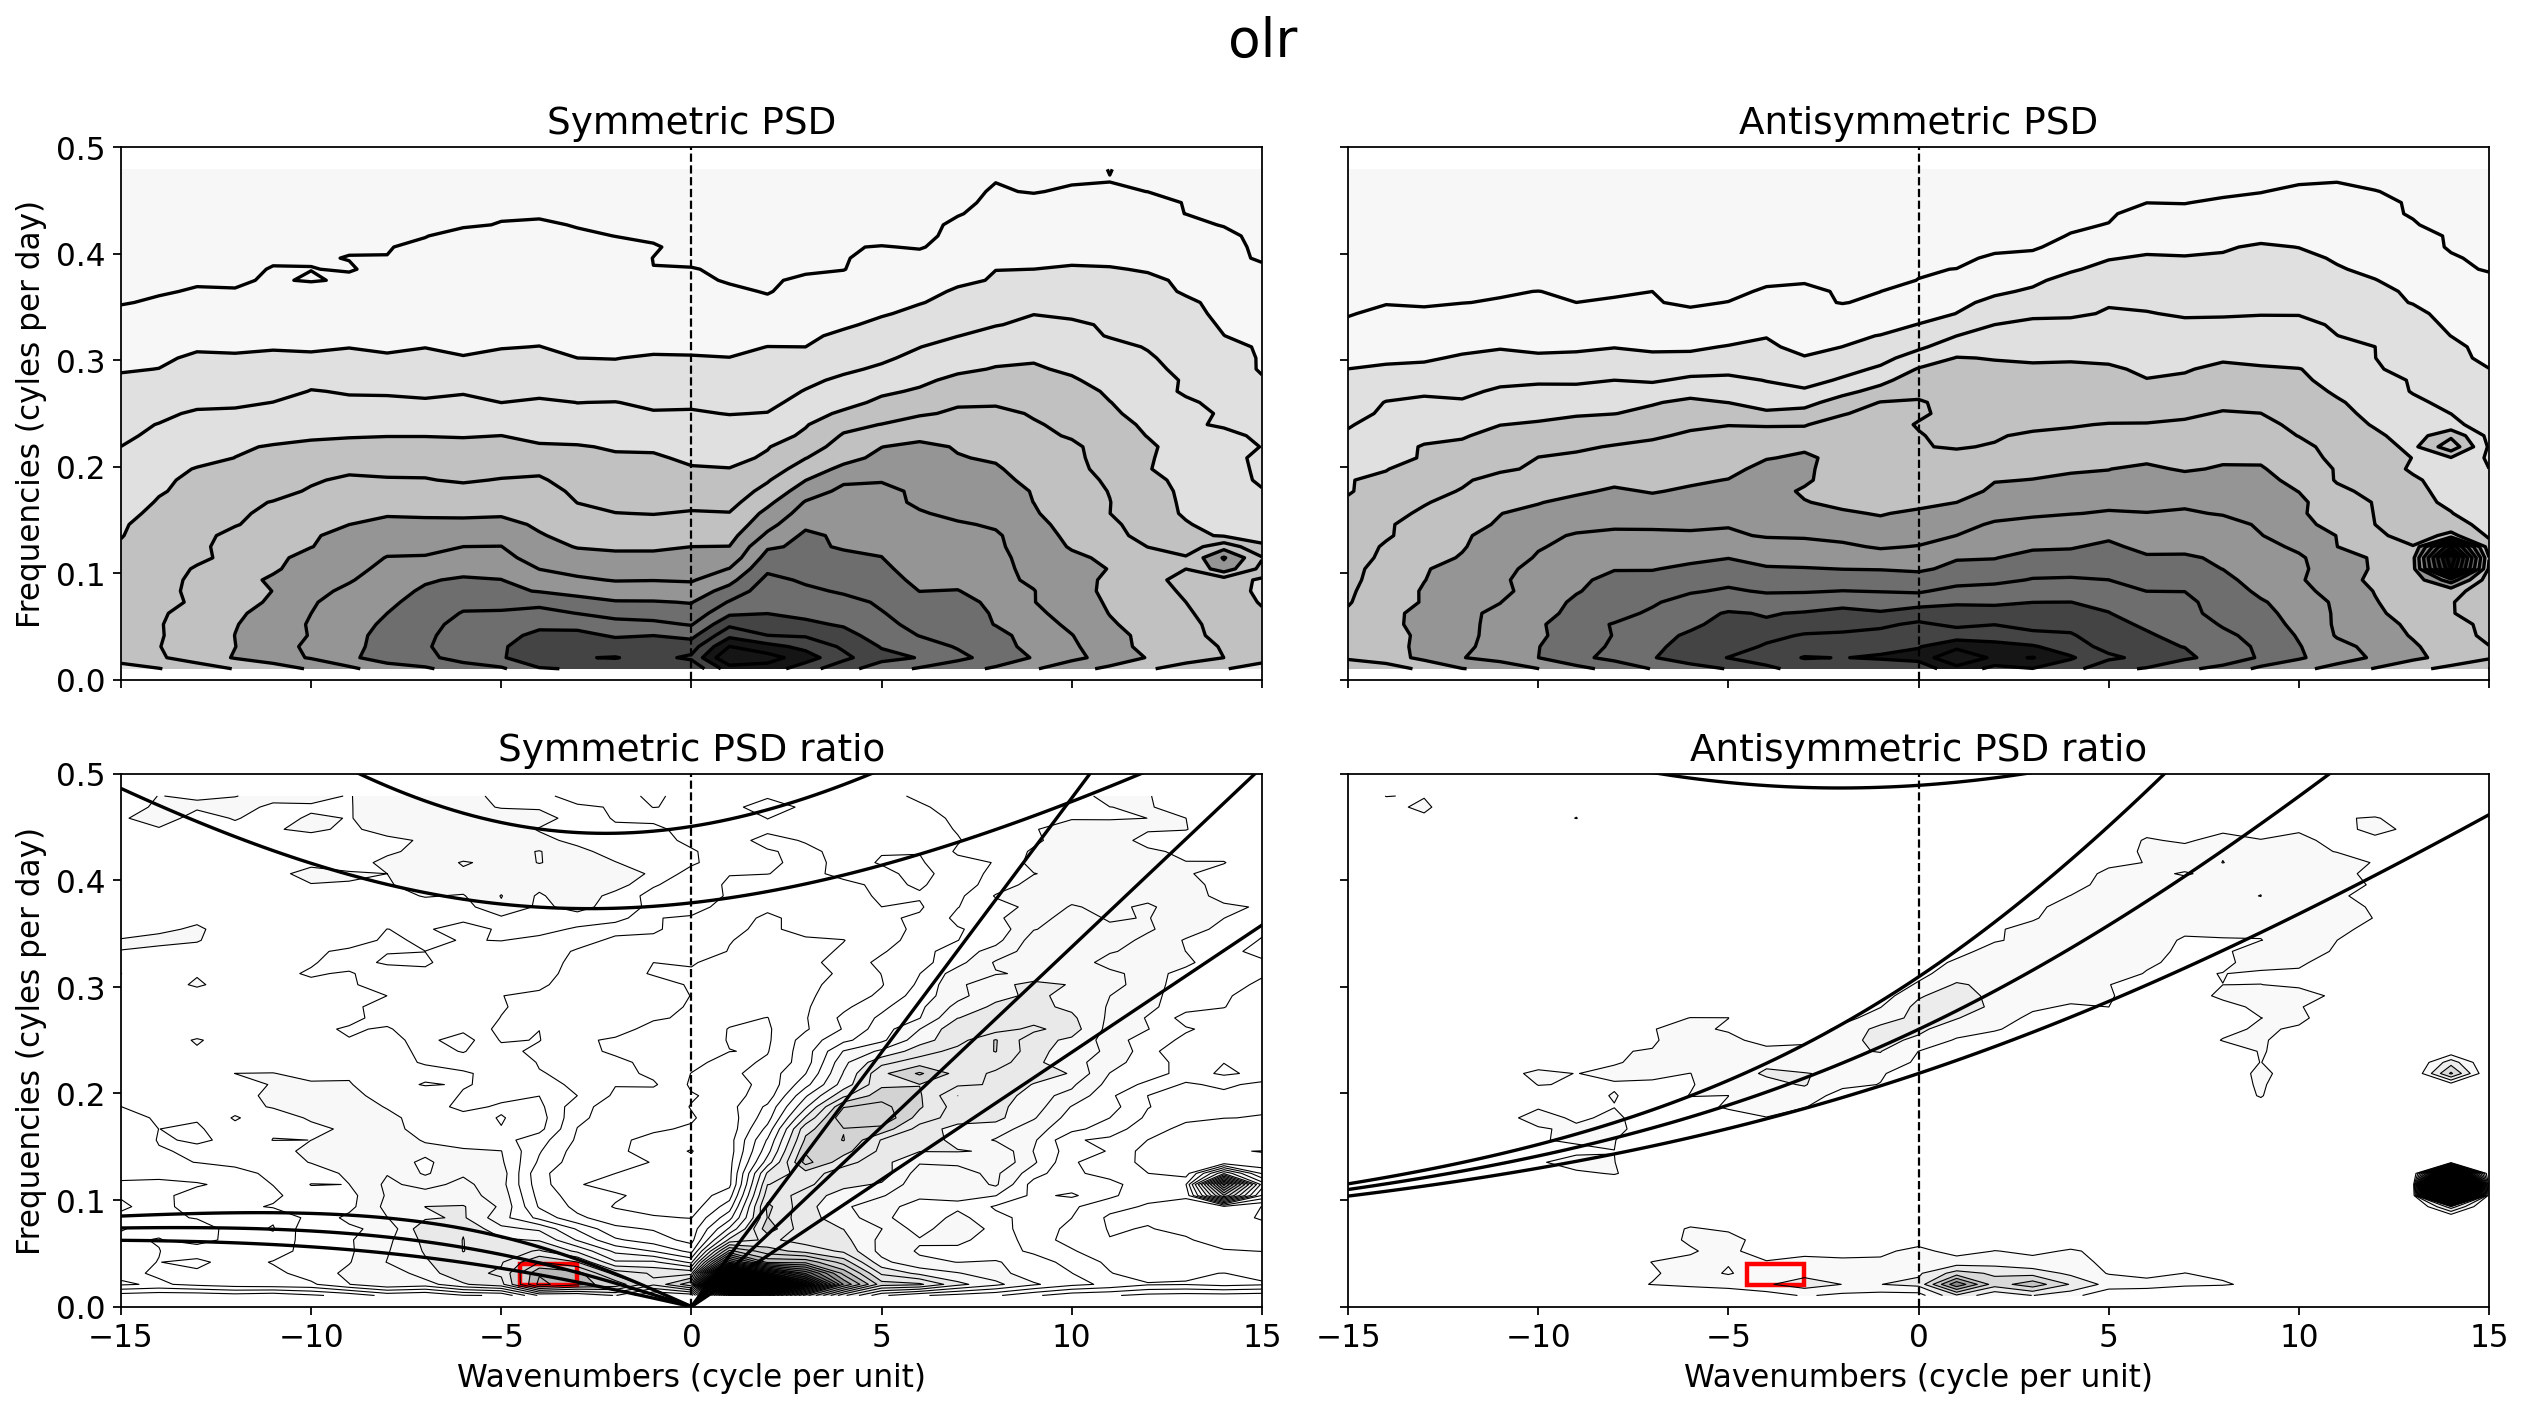

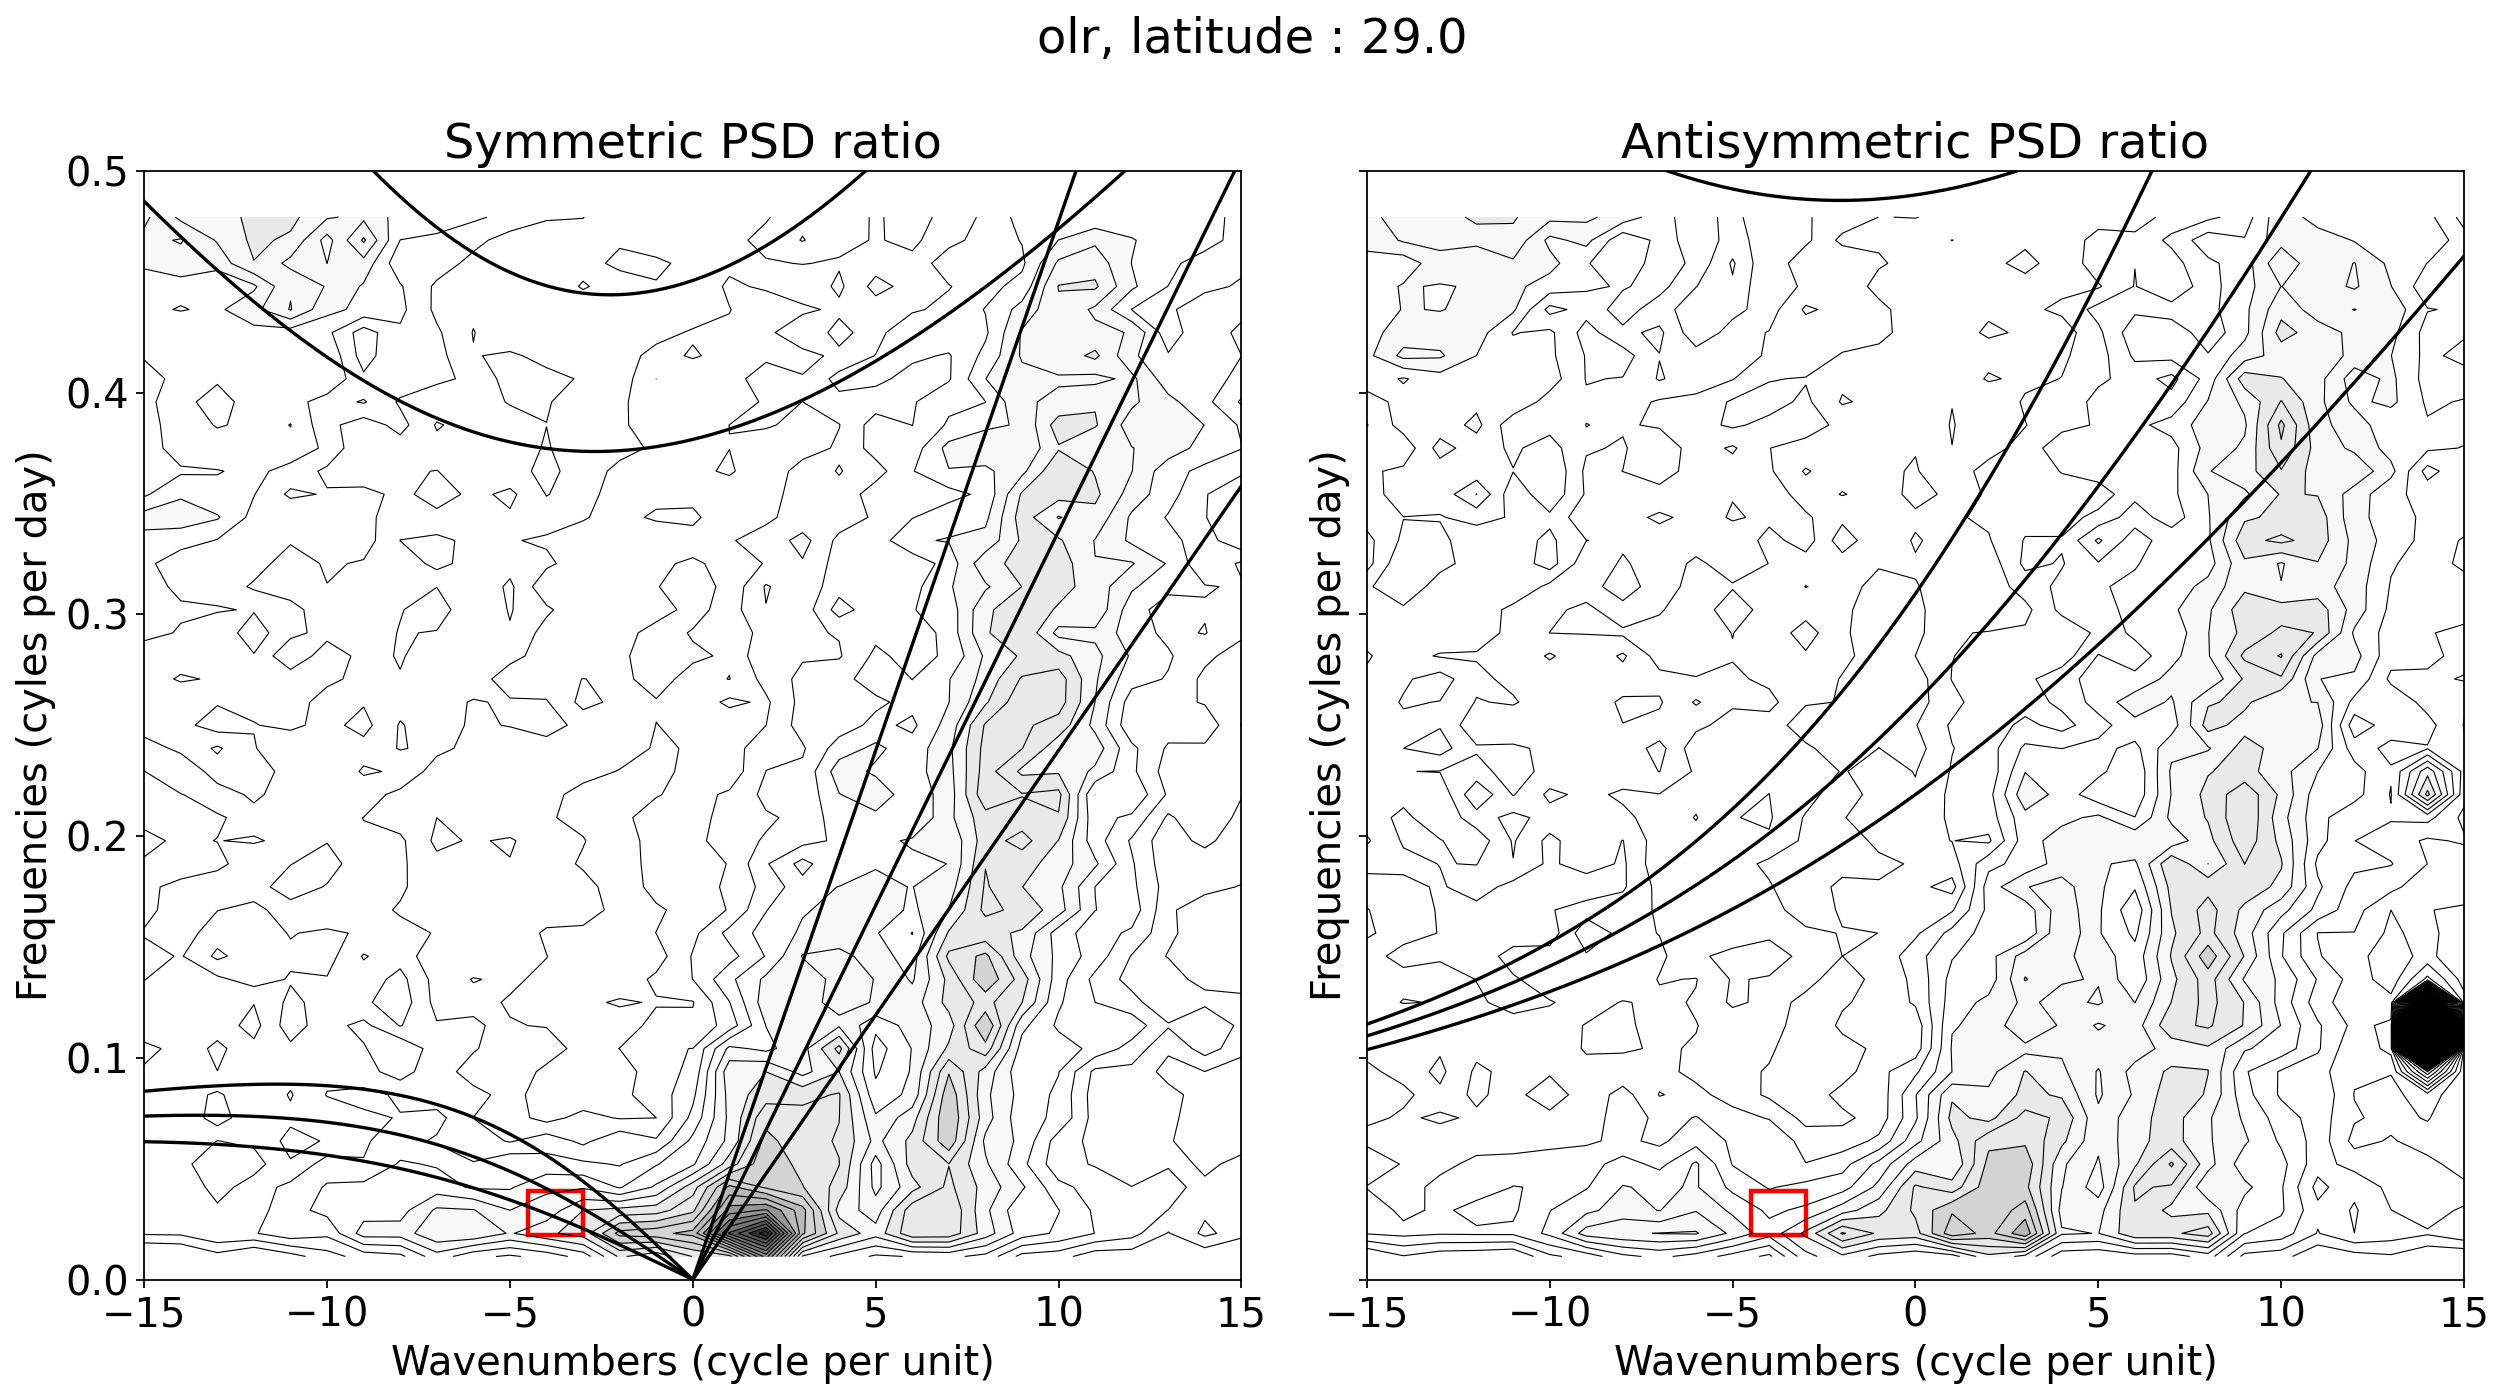

In [7]:
if do_preliminary_analysis_2:
    importlib.reload(plotter)
    with time_block("Plotting of Stochastic Power Spectra Density Ratio"):
        # filter_wnfr = [(3.5, 0.15), 2, 0.05]
        filter_wnfr = [(-4.5, 0.02), 1.5, 0.02]
        fig, axes = plotter.display_wavenumber_frequency_diagram(
            symmetric_PSD,
            antisymmetric_PSD,
            background_PSD,
            grids,
            box=filter_wnfr,
            variable_name=varname,
        )
        fig.savefig(
            os.path.join(
                ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
                f"{varname}_wavenumber_frequency_diagram.png",
            )
        )
    with time_block("Wavenumber-Frequency Diagram TEST"):
        animation_object = plotter.display_wavenumber_frequency_diagram_evolution(
            symmetric_PSD,
            antisymmetric_PSD,
            background_PSD,
            grids,
            box=filter_wnfr,
            variable_name=varname,
        )
        _ = animation_object.save(
            os.path.join(
                ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
                f"{varname}_wavenumber_frequency_diagram_evolution.mp4",
            )
        )

In [8]:
filtered_symmetric_components, filtered_antisymmetric_components, _ = (
    calculations.calculate_filtered_signal(
        file_path=filepath,
        zonal_wavenumber_limit=np.array(
            [filter_wnfr[0][0], filter_wnfr[0][0] + filter_wnfr[1]]
        ),
        segmentation_frequency_limit=np.array(
            [filter_wnfr[0][1], filter_wnfr[0][1] + filter_wnfr[2]]
        ),
        variable_name=varname,
    )
)

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.animation as animation

# Configure plot aesthetics
plt.rcParams.update({"font.size": 28})
figure, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(25, 9),
    dpi=160,
    sharex=True,
    sharey=True,
    subplot_kw={"projection": ccrs.PlateCarree()},
)


def init_animation():
    """Initialize the animation."""
    return []


def update_frame(days):
    """Update the animation frame by frame."""

    # Plot Early Onset Composite
    ax.cla()
    cf1 = ax.contourf(
        grids["lon"],
        grids["lat"],
        np.real(filtered_symmetric_components[days, :, :]),
        levels=np.linspace(-10, 10, 32),
        extend="both",
        cmap="RdBu_r",
        transform=ccrs.PlateCarree(),
    )
    ax.plot([0, 359], [0, 0], "k--", lw=2, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([-180, 180, -29, 29], crs=ccrs.PlateCarree())
    ax.set_ylabel("Longitude")
    ax.set_xlabel("Latitude")
    # Update the figure's super title
    figure.suptitle(f"{varname},  day: {days}")

    return []


# Create the animation
animation_obj = animation.FuncAnimation(
    figure,
    update_frame,
    frames=360,
    interval=200,
    init_func=init_animation,
)
_ = animation_obj.save(
    os.path.join(
        ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
        f"{varname}_filter_test.mp4",
    )
)

Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 4000x1440 -pix_fmt rgba -framerate 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/b08209033/IndianMonsoon/img/olr_filter_test.mp4


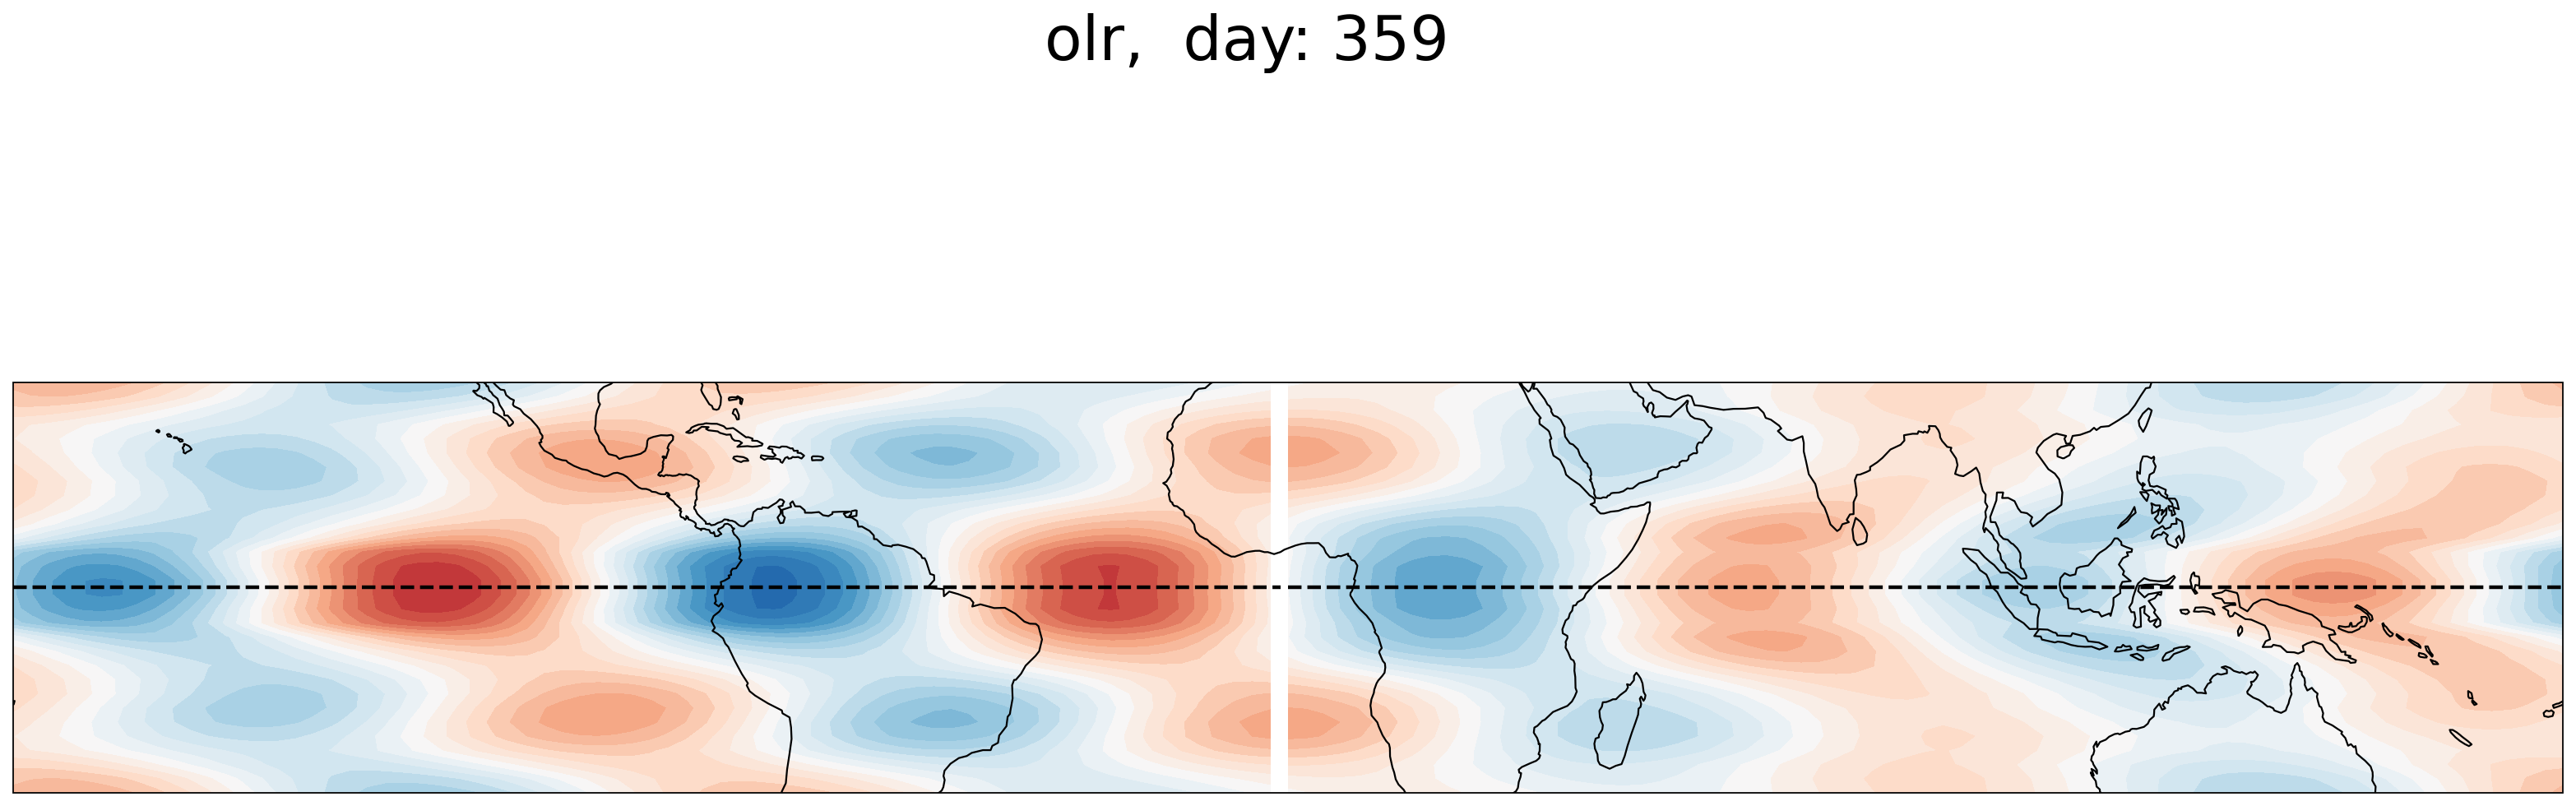

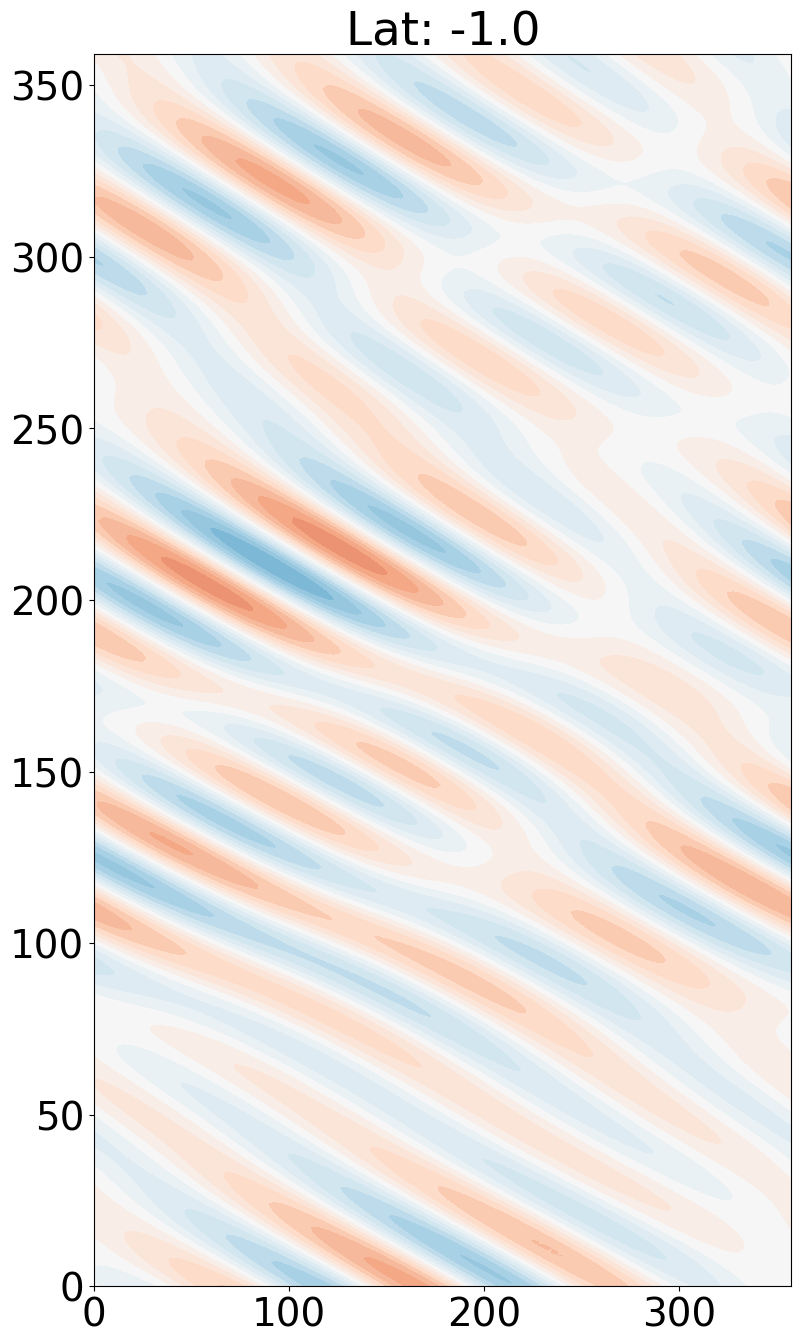

In [10]:
ilat = 14
plt.ion()
plt.figure(figsize = (9,16))
plt.contourf(
    grids["lon"],
    np.arange(360),
    np.real(filtered_symmetric_components[360*2:360*3, ilat, :]),
    levels=np.linspace(-20, 20, 32),
    extend="both",
    cmap="RdBu_r",
)
plt.title(f"Lat: {grids["lat"][ilat]}")
plt.show()
